In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Cross-validation
from sklearn.model_selection import cross_val_score

# Feature importance (for tree-based models)
from sklearn.inspection import permutation_importance

# Saving models
import joblib


In [3]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Overview of the data
print(train_data.head())
print(test_data.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
  

In [4]:
# Drop unnecessary columns
columns_to_drop = ["Destination", "VIP","Name"]
train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)


In [5]:
print(train_data_cleaned.head())
print(test_data_cleaned.head())

  PassengerId HomePlanet CryoSleep  Cabin   Age  RoomService  FoodCourt  \
0     0001_01     Europa     False  B/0/P  39.0          0.0        0.0   
1     0002_01      Earth     False  F/0/S  24.0        109.0        9.0   
2     0003_01     Europa     False  A/0/S  58.0         43.0     3576.0   
3     0003_02     Europa     False  A/0/S  33.0          0.0     1283.0   
4     0004_01      Earth     False  F/1/S  16.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  
0           0.0     0.0     0.0        False  
1          25.0   549.0    44.0         True  
2           0.0  6715.0    49.0        False  
3         371.0  3329.0   193.0        False  
4         151.0   565.0     2.0         True  
  PassengerId HomePlanet CryoSleep  Cabin   Age  RoomService  FoodCourt  \
0     0013_01      Earth      True  G/3/S  27.0          0.0        0.0   
1     0018_01      Earth     False  F/4/S  19.0          0.0        9.0   
2     0019_01     Europa      True  C/0/S 

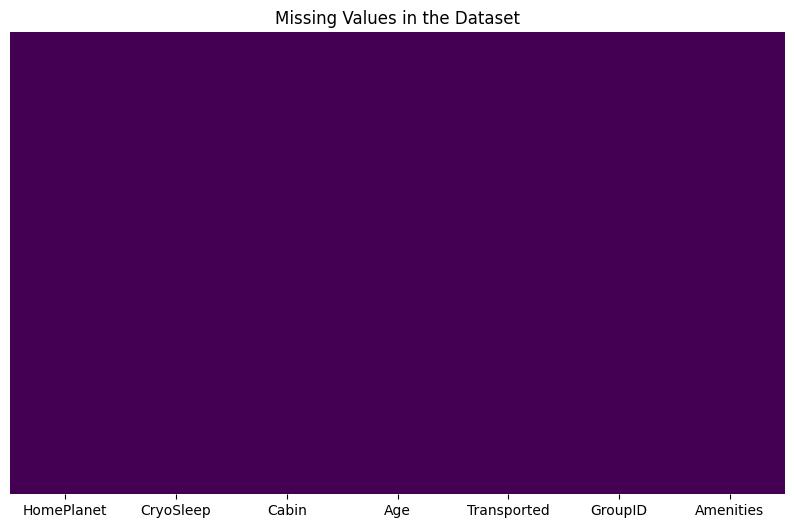

In [26]:
# Combine train and test data for visualization purposes
combined_data = pd.concat([train_data_cleaned], axis=0, ignore_index=True)

# Plot missing values
plt.figure(figsize=(10, 6))
sns.heatmap(combined_data.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values in the Dataset")
plt.show()

Handling Missing Values

In [7]:

mean_age = train_data_cleaned['Age'].mean()
train_data_cleaned['Age'].fillna(mean_age, inplace=True)

# Fill missing values in 'HomePlanet' with the mode (Earth)
train_data_cleaned['HomePlanet'].fillna('Earth', inplace=True)


In [9]:
# Define a function to impute CryoSleep based on amenities usage
def impute_cryosleep(row):
    # Check if any of the amenities have a spending greater than 0
    if row[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum() == 0:
        return True  # No spending, likely in CryoSleep
    else:
        return False  # Spent money, likely not in CryoSleep

# Apply the function to handle missing CryoSleep values
train_data_cleaned['CryoSleep'] = train_data_cleaned.apply(
    lambda row: impute_cryosleep(row) if pd.isnull(row['CryoSleep']) else row['CryoSleep'], axis=1
)

In [14]:
# Extract GroupID from PassengerId
#train_data_cleaned['GroupID'] = train_data_cleaned['PassengerId'].str.split('_').str[0]

print(train_data_cleaned['GroupID'].head())


0    0001
1    0002
2    0003
3    0003
4    0004
Name: GroupID, dtype: object


In [12]:
#Drop 'PassengerId' and keep 'GroupID' for modeling purposes
#train_data_cleaned.drop('PassengerId', axis=1, inplace=True)

In [16]:
# For missing 'Cabin', assign the same cabin as another passenger in the same group or a default value if no cabins are available
def impute_cabin(row):
    if pd.isnull(row['Cabin']):
        group_id = row['GroupID']
        # Get non-null cabins for the same group
        group_cabin_values = train_data_cleaned[train_data_cleaned['GroupID'] == group_id]['Cabin'].dropna()
        
        if not group_cabin_values.empty:
            # If there are non-null cabins, assign the first one
            return group_cabin_values.iloc[0]
        else:
            # If there are no non-null cabins in the group, assign 'Unknown'
            return 'Unknown'
    else:
        return row['Cabin']

# Apply the function to handle missing 'Cabin' values
train_data_cleaned['Cabin'] = train_data_cleaned.apply(impute_cabin, axis=1)


In [21]:
# Set values for amenities to 0 for passengers in CryoSleep
train_data_cleaned.loc[train_data_cleaned['CryoSleep'] == True, 
                       ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0

In [23]:
# Combine the 5 amenities columns into one binary column 'Amenities'
train_data_cleaned['Amenities'] = train_data_cleaned[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(
    lambda row: 1 if (row > 0).any() else 0, axis=1)


In [25]:
# Drop the original amenity columns
train_data_cleaned.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

In [41]:
print(train_data_cleaned.head(10))

  HomePlanet  CryoSleep   Age  Transported GroupID  Amenities  DeckRank  \
0     Europa          0  39.0            0    0001          0         1   
1      Earth          0  24.0            1    0002          1         6   
2     Europa          0  58.0            0    0003          1         4   
3     Europa          0  33.0            0    0003          1         4   
4      Earth          0  16.0            1    0004          1         6   
5      Earth          0  44.0            1    0005          1         6   
6      Earth          0  26.0            1    0006          1         6   
7      Earth          1  28.0            1    0006          0         3   
8      Earth          0  35.0            1    0007          1         6   
9     Europa          1  14.0            1    0008          0         1   

   SideRank  
0       2.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0  
5       2.0  
6       1.0  
7       1.0  
8       1.0  
9       2.0  


In [28]:
# Convert 'CryoSleep' and 'Transported' columns to numeric (1 and 0)
train_data_cleaned['CryoSleep'] = train_data_cleaned['CryoSleep'].astype(int)
train_data_cleaned['Transported'] = train_data_cleaned['Transported'].astype(int)


In [31]:
# Split 'Cabin' into 'Deck' and 'Side'
train_data_cleaned['Deck'] = train_data_cleaned['Cabin'].str.split('/').str[0]  # Extract deck
train_data_cleaned['Side'] = train_data_cleaned['Cabin'].str.split('/').str[2]  # Extract side

# Drop the original 'Cabin' column
train_data_cleaned.drop(columns=['Cabin'], inplace=True)

In [33]:
# Calculate danger ranking for Deck
deck_danger = train_data_cleaned.groupby('Deck')['Transported'].mean().sort_values(ascending=False).reset_index()
deck_danger['DangerRank'] = range(1, len(deck_danger) + 1)

# Map the danger rank back to the Deck column
deck_rank_map = dict(zip(deck_danger['Deck'], deck_danger['DangerRank']))
train_data_cleaned['DeckRank'] = train_data_cleaned['Deck'].map(deck_rank_map)